# Computational Methods in Economics

## Problem Set 5 - Numerical Optimization 

In [1]:
# Author: Alex Schmitt (schmitt@ifo.de)

import datetime
print('Last update: ' + str(datetime.datetime.today()))

Last update: 2018-12-14 14:43:09.821885


### Preliminaries

#### Import Modules

In [2]:
import numpy as np
import scipy.optimize
import scipy.linalg

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

## Question 1 (N)

*From Judd(1998), chapter 4, question 2*. One of the classical uses of optimization is the computation of the *Pareto frontier*. Consider the endowment economy with $m$ goods and $n$ agents. Assume that agent $i$'s utility function over the $m$ goods is 

\begin{equation}
    u^{i}(x^i) = \sum^{m}_{j = 1} a^i_j (x^i_j)^{v^i_j + 1} (1 + v^i_j)^{-1} 
\end{equation}

Suppose that agent $i$'s endowment of good $j$ is $e^i_j$. Assume that $a^i_j, e^i_j > 0 > v^i_j$ (for $v^i_j =-1$, we replace $(x^i_j)^{v^i_j + 1} (1 + v^i_j)^{-1}$ with $\ln x^i_j$). 

(a) Write a program using Scipy's BFGS implementation that will read in the $v^i_j$, $a^i_j$ and $e^i_j$ and the social weights $\lambda^i$, and output the solution to the social planner's problem. Choose $m = n = 2$ and solve the problem *analytically* for $\lambda_1 = \lambda_2 = 0.5$ and the following values for the remaining parameters: 

In [3]:
E = np.array([[6., 4.], [5., 1.]])
V = np.array([[-4., -2.], [-3., -3.]])
A = np.array([[1., 4.], [1., 8.]])

print("V = {}".format(V) )
print("A = {}".format(A) )
print("E = {}".format(E) )

V = [[-4. -2.]
 [-3. -3.]]
A = [[1. 4.]
 [1. 8.]]
E = [[6. 4.]
 [5. 1.]]


The way to read these matrices is that a good corresponds to a row and an agent to a column. For example, agent 1's endowment of good 2, $e^1_2$, would be the element in the second row and first column of matrix **E**, and hence $e^1_2 = 5$.

With these parameter values, confirm your analytical result equals the numerical output of your program. 

(b) Test your program for higher numbers of goods and agents. You can create the parameter matrices above using Numpy's **np.random.uniform** function. Can your program handle $m = n = 5$? $m = n = 10$?      


**Hint**: A slightly tricky issue when answering this question using *unconstrained* numerical optimization methods is how to deal with the constraint that aggregate consumption of good $j$ must equal aggregate endowments, i.e.

\begin{equation}
    \sum^{n}_{i = 1} x_j^i = \sum^{n}_{i = 1} e_j^i
\end{equation}

One way to address this is to have the algorithm solve for the optimal consumption for $n - 1$ agents and evaluate the consumption and hence the utility of the last agent *as the residual*. formally, for good $j$,

\begin{equation}
    x_j^n = \sum^{n}_{i = 1} e_j^i - \sum^{n-1}_{i = 1} x_j^i
\end{equation}

### Answers

For the analytical solution to the 2-by-2 case, compare the notes in class. 

For the numerical implementation, start by addressing the issue of the endowment constraints discussed above. The function **consum(x, E)** takes a vector **x** (the consumption levels for the first $n-1$ agents) and the endowment matrix **E** and returns a consumption matrix **X**, in which the last column (the consumption of agent $n$) is computed as the residual.

As a side note, why do we define **consum** in a way that it takes a vector (i.e. a one-dimensional array) rather than a two-dimensional matrix as an input? Note that **scipy.optimize.minimize** returns a vector (even if we use a matrix as an initial, as seen below!) and hence we need to write **consum** in a way that it accommodates this. 

In [4]:
def consum(x, E):
    """
    Computes an m-by-n consumption matrix from solution vector x and endowments E;
    Agent n's consumption is computed as the residual comsumption 
    """
    ## get dimension of the endowment matrix
    m, n = E.shape 
    ## check that x and E have consistent dimensions
    assert len(x) == m * (n-1), "The length is not consistent with the dimensions of E!"
    
    ## reshape x into matrix X 
    X = x.copy()
    X.shape = m, n - 1
    
    ## compute residual consumption
    x_res = E.sum(axis = 1) - X.sum(axis = 1)
    
    ## combine X with x_res and return
    return np.column_stack( (X, x_res) )


Using **consum**, it is straightforward to implement the objective function $U = \sum^n_{i = 1} \lambda^i u^{i}(x^i)$:

In [5]:
def objective(x, V, A, E, lam):
    """
    Computes the objective function for the m-by-n social planner problem
    """
    ## get dimension of the problem 
    m, n = V.shape ## number of agents, number of good

    ## check if the parameter matrices have the correct dimensions 
    assert A.shape == (m, n), "The dimensions of A and V must coincide!"
    assert E.shape == (m, n), "The dimensions of E and V must coincide!"
    assert len(lam) == n, "The length of lam is not consistent with the dimensions of V!"
    
    ## compute matrices of consumption using x and endowment matrix E
    X = consum(x, E)
    
    ## loop over agents and evaluate their utility
    u = np.zeros(n)
    for ind in range(n):
        v, a = V[:, ind], A[:, ind]
        Q = a / (1 + v)
        u[ind] = Q @ X[:,ind]**(1 + v)

    ## compute welfare given weights lam (NB: we could use summation instead of vector multiplication )
    return - lam @ u


We solve the problem using the BFGS algorithm for 2-by-2 case. As an initial guess, use the agents' endowment.

In [6]:
x0 =  E[:, :-1]
lam = np.array([0.5, 0.5])
objective(x0, V, A, E, lam)
res = scipy.optimize.minimize(objective, x0, method = 'BFGS', args = (V, A, E, lam), options = {'disp': True})
x = res.x

print("Consumption matrix: ")
print( consum(x, E) )

Optimization terminated successfully.
         Current function value: 0.458333
         Iterations: 16
         Function evaluations: 72
         Gradient evaluations: 18
Consumption matrix: 
[[1.99999254 8.00000746]
 [2.00000424 3.99999576]]


### m = 3, n = 2

We can check that the algorithm works in a setting with more goods than agents:

In [7]:
E = np.array([[2., 1.], [2., 2.], [2., 3.]])
V = np.array([[-2., -4.], [-3., -2.], [-5., -2.]])
A = np.array([[1., 1.], [1., 2.], [1., 3.]])

x0 =  E[:, :-1]
lam = np.array([0.5, 0.5])
res = scipy.optimize.minimize(objective, x0, method = 'BFGS', args = (V, A, E, lam), options = {'disp': True})
x = res.x

print("Consumption matrix: ")
print( consum(x, E) )

Optimization terminated successfully.
         Current function value: 1.329515
         Iterations: 8
         Function evaluations: 45
         Gradient evaluations: 9
Consumption matrix: 
[[1.69723441 1.30276559]
 [1.47265462 2.52734538]
 [1.34772323 3.65227677]]


### m = 6, n = 6

In [8]:
m, n = 6, 6
E = np.random.uniform(1, 5, (m, n))
V = np.random.uniform(-5, -1.001, (m, n))
A = np.random.uniform(1, 3, (m, n))

In [9]:
x0 = E[:, :-1]
lam = np.ones(n) * (1/n)
res = scipy.optimize.minimize(objective, x0, method = 'BFGS', args = (V, A, E, lam), options = {'disp': True})
x = res.x

print("Consumption matrix: ")
print( consum(x, E) )

Optimization terminated successfully.
         Current function value: 6.663442
         Iterations: 91
         Function evaluations: 2976
         Gradient evaluations: 93
Consumption matrix: 
[[4.47993552 2.25127022 3.30683165 3.27816417 2.58160917 5.27907715]
 [9.62593192 1.56279095 1.66457392 2.08378085 2.746518   1.72673169]
 [5.12384792 2.93458866 1.96895529 3.9901752  2.3849288  2.13699173]
 [2.04864918 8.30810872 1.88714786 2.00644759 2.9753713  2.4970475 ]
 [2.22313084 5.81201221 3.83504054 2.32292384 6.36966501 4.01918305]
 [2.04415783 2.279997   3.26053463 1.99764592 4.26553828 6.22829564]]


## Question 2 (N)

Consider the neoclassical growth model from the lecture. In this question, we extend it so that the production function contains *energy* $m_t$ as a third production factor in addition to capital and labor. Hence, output is given by

\begin{equation}
    y_t = f(k_t, h_{y,t}, m_t) = A k_t^\alpha m_t^\gamma h_{y,t}^{1-\alpha-\gamma}
\end{equation}

Energy is itself produced by using a part of the labor supply:

\begin{equation}
    m_t = \rho h_{m,t}
\end{equation}

which implies that one unit of labor supply creates $\rho$ units of energy.

Solve the planner problem numerically for $T = 30$. Note that lifetime utility is still given by 

\begin{equation}
    u(c_t, h_t) = \frac{c^{1-\nu}}{1-\nu} - B \frac{h_t^{1+\eta}}{1+\eta}
\end{equation}

with $h_t = h_{y,t} + h_{m,t}$. You can use the parameter values from the lecture, and $\gamma = 0.05$ and $\rho = 0.9$. 

In addition, compute the steady state using a root finding algorithm and verify that the planner's sequences for $k_t$, $h_{y,t}$ and $h_{m,t}$ converge to their steady state values.

### Answer

#### Parameters

In [10]:
## utility
beta = 0.9      # discount factor
nu = 2       # risk-aversion coefficient for consumption
eta = 1         # elasticity parameter for labor supply

## production
alpha = 0.25
gamma = 0.05
rho = 0.9
delta = 0.1
## derived
A = (1 - beta * (1 - delta))/(alpha*beta)  # productivity
B = (1 - alpha) * A * (A - delta)**nu      # parameter for utility function
## initial capital stock
k0 = 0.8

#### Functions

In [11]:
def cd(k, m, hy):
    """
    Evaluates the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return A * k**alpha * m**gamma * hy**(1 - alpha - gamma)

def u(c, h):
    """
    Utility function
    """
    return c**(1 - nu)/(1 - nu) - B * h**(1 + eta)/(1 + eta)

def objective(x):
    """
    Objective function: lifetime utility
    """
    kp = np.exp( x[:int(len(x)/3)] )
    hy = np.exp( x[int(len(x)/3): 2 * int(len(x)/3)] )
    hm = np.exp( x[2 * int(len(x)/3):] )

    k = np.insert(kp[:T-1], 0, k0)
    
    return - ( beta**(np.array(range(T))) @ u( cd(k, rho * hm, hy) + (1 - delta) * k - kp, hy + hm)
              + (beta**T/(1 - beta)) *  u( cd(kp[-1], rho * hm[-1], hy[-1]) - delta * kp[-1] , hy[-1] + hm[-1]) )

#### Solving the steady state

In [12]:
def cobb_douglas(x, alpha, gamma, A):
    """
    Evaluates the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return A * x[0]**alpha * (rho * x[2])**(gamma) * x[1]**(1 - alpha - gamma)

In [13]:
def cd_diff(x, alpha, gamma, A):
    """
    Returns the first derivative of the cobb douglas wrt k, hy and hm
    """
    return (alpha * cobb_douglas(x, alpha, gamma, A) / x[0], 
            (1 - alpha - gamma) * cobb_douglas(x, alpha, gamma, A) / x[1],
            gamma * cobb_douglas(x, alpha, gamma, A) / x[2])
    

In [14]:
def steady(x):
    """
    Returns the vector-valued function consisting of the steady-state conditions 
    """
    y = np.zeros(3)
    X = np.exp(x)
    mp = cd_diff(X, alpha, gamma, A)
    
    y[0] = beta * (mp[0] + 1 - delta) - 1
    y[1] = (cobb_douglas(X, alpha, gamma, A) - delta * X[0])**(-nu) * mp[1] - B * (X[2] + X[1])**eta
    y[2] = mp[1] - mp[2]
    
    return y

In [15]:
x0 = np.log([1.2, 1.4, 0.2])
res_ss = scipy.optimize.root(steady, x0, method = 'broyden1', options = {'line_search' : None, 'jac_options': {'alpha': 1}})
print(res_ss)

kss = np.exp(res_ss.x)[0]
hyss = np.exp(res_ss.x)[1]
hmss = np.exp(res_ss.x)[2]

print( "Steady state: (K_ss, hy_ss, hm_ss) = {}".format(np.exp(res_ss.x) ) )

     fun: array([ 0.00000000e+00, -1.26660680e-06, -2.77555756e-16])
 message: 'A solution was found at the specified tolerance.'
     nit: 94
  status: 1
 success: True
       x: array([ 0.22552077,  0.40848196, -2.23057537])
Steady state: (K_ss, hy_ss, hm_ss) = [1.25297506 1.50453212 0.10746658]


#### Solving the model numerically

In [16]:
T = 30

## set initial guess    
x0 = np.concatenate([np.log( 1.2 ) * np.ones(T), np.log( 1.5 ) * np.ones(T), np.log( 0.09 ) * np.ones(T)])

## solve model
res = scipy.optimize.minimize(objective, x0, method = 'BFGS', tol = 1e-6)
print(res.message)
print(res.success)
x = res.x
kp = np.exp( x[:int(len(x)/3)] )
hy = np.exp( x[int(len(x)/3): 2 * int(len(x)/3)] )
hm = np.exp( x[2 * int(len(x)/3):] )

Optimization terminated successfully.
True


In [17]:
res

      fun: 15.95642654445973
 hess_inv: array([[ 4.47769626e-01,  2.56326478e-01,  1.58080848e-01, ...,
        -5.02637971e-02, -1.50139151e-01, -3.87164324e-02],
       [ 2.56326478e-01,  5.66210374e-01,  3.39401024e-01, ...,
        -9.34447024e-02, -2.20502904e-01, -8.10468754e-02],
       [ 1.58080848e-01,  3.39401024e-01,  6.35835087e-01, ...,
        -7.56924113e-02, -1.81125458e-01, -9.91180563e-02],
       ...,
       [-5.02637971e-02, -9.34447024e-02, -7.56924113e-02, ...,
         4.02693032e+01,  4.31456538e+01, -8.82324233e-01],
       [-1.50139151e-01, -2.20502904e-01, -1.81125458e-01, ...,
         4.31456538e+01,  1.16751638e+02, -4.46488225e+00],
       [-3.87164324e-02, -8.10468754e-02, -9.91180563e-02, ...,
        -8.82324233e-01, -4.46488225e+00,  8.85287977e+00]])
      jac: array([ 2.38418579e-07,  4.76837158e-07, -4.76837158e-07,  2.38418579e-07,
        0.00000000e+00,  2.38418579e-07,  1.19209290e-07,  0.00000000e+00,
        0.00000000e+00,  2.38418579e-07,  

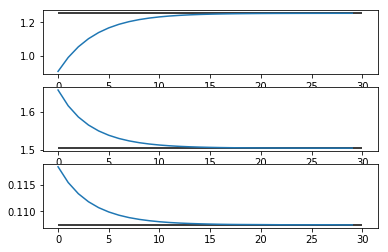

In [18]:
fig, ax = plt.subplots(3,1)
ax[0].plot(kp)
ax[1].plot(hy)
ax[2].plot(hm)
ax[0].hlines(kss, 0, T)
ax[1].hlines(hyss, 0, T)
ax[2].hlines(hmss, 0, T)

## Question 3 (A)

Show that for an arbitrary $m$-by-$n$ matrix $A$ with $m \ge n$ and rank $n$ - i.e., that has linearly independent columns - the matrix product $A^T A$ is positive definite and symmetric. Recall that a square matrix $B$ of order $n$ is *positive definite* if there is a positive scalar such that

\begin{equation}
    \mathbf{x}^T B x \ge \alpha \mathbf{x}^T \mathbf{x} \quad \text{for all} \quad \mathbf{x} \in \mathbb{R}^n.
\end{equation}


## Question 4 (N)

Use gradient descent to solve the monopoly example from lecture 5a, which is summarized in the cells below. That is, define a **step** function for gradient descent that can be used use in the **my_opt** routine, also given below. The distance $\alpha$ should be fixed for a given run of the algorithm, but you can play around with different values. 

In [19]:
### functions and parameters
alpha = 0.98
eta = 0.85

cy = 0.62
cz = 0.6

Cy = lambda x : cy * x
Cz = lambda x : cz * x

In [20]:
def u(Y, Z):
    """
    Returns the u function.
    """
    return (Y**alpha + Z**alpha)**(eta/alpha)

def ud(Y, Z):
    """
    Returns the derivative of the u function.
    """
    return eta * (Y**alpha + Z**alpha)**(eta/alpha - 1) * Y**(alpha - 1)

In [21]:
def obj(x):
    """
    Implements the objective function (here profit) for the monopoly example: Y * ud(Y, Z) + Z * ud(Z, Y) - Cy(Y) - Cz(Z)
    """
    Y = np.exp(x[0])
    Z = np.exp(x[1])
    
    return - (Y * ud(Y, Z) + Z * ud(Z, Y) - Cy(Y) - Cz(Z))

In [22]:
def my_opt(x, obj, step, maxit = 100, eps = 1e-8, delta = 1e-4):
    """
    Implements the iterative procedure for all of the optimization algorithms considered below. 
    Mandatory inputs are 
    -> x: initial guess for the minimizing vector
    -> obj: objective, defined a function of x
    -> step: a function implementing how the step from x(k) to x(k+1) is determined
    """
    dist = 1
    it = 0
    
    lx = []
    while dist > eps and it < maxit:
        lx.append(x)
        it += 1
    
        s, alpha = step(x, obj)
    
        dist = np.linalg.norm(s) / (1 + np.linalg.norm(x))

        x = x + s
    
    ## check for optimality
    gr = sm.tools.numdiff.approx_fprime(x, obj)
    if np.linalg.norm(gr) > delta * (1 + abs(obj(x))):
        print('Solution does not appear an optimum!')
    
    return x, lx  

### Answer

In [23]:
def descent(x, obj):
    
    gr = sm.tools.numdiff.approx_fprime(x, obj)
    p = -gr
    
    alpha = 2
    
    return (alpha * p , alpha)

In [24]:
x0 = np.array([1.5, 2])
x, lx = my_opt(x0, obj, descent, maxit = 500)
print("Equilibrium quantities: {}".format(np.exp(x)))

Equilibrium quantities: [0.56984271 2.9356177 ]


## Question 5 (N)

In this question, we are going to apply the gradient descent minimization algorithm on a least-squares regression problem. Consider the Bundesliga data set used in the *Introduction to Python* section of this class. Let's assume we would like to regress a player's market value on his age, his number of goals and assists. Running the following cell (i) reads in the relevant columns of the data set; (ii) creates a matrix **'X'** with the explanatory variables; and (iii) creates an array **'y'** containing the dependent variables.

In [25]:
cols=(2,4,5,6)
D = np.loadtxt('BundesligaData.txt', delimiter=';',usecols=(cols), skiprows=1)
D[:10, :]

description = ['name', 'position', 'value', 'valuemax', 'age', 'goals','assists', 'yellow', 'red', 'shotspergame','passsuccess','aerialswon', 'rating', 'positioncode']
for i in cols:
    print((i,description[i]))

X = D[:,1:]
## dependent variable
y = D[:,0] 
y.shape=(D.shape[0], 1)
# Before regressing the values, we should check whether X and y have the right shape
print(X.shape)
print(y.shape)

print(X[:10, :])     

(2, 'value')
(4, 'age')
(5, 'goals')
(6, 'assists')
(291, 3)
(291, 1)
[[28. 30.  4.]
 [27. 29.  2.]
 [27.  5. 12.]
 [27.  5.  4.]
 [26.  4.  3.]
 [20.  6. 11.]
 [26.  2.  2.]
 [28. 10.  2.]
 [20.  2.  1.]
 [20.  2.  1.]]


(a) Scale the values in **X** and add a column of ones. 

(b) For comparison, use the normal equation to compute $\mathbf{b}$.

(c) Implement the gradient descent algorithm outlined above to find $\mathbf{b}$. Assume that the step size $\alpha$ is constant. You may have to play around with $\alpha$ to find a value that gives you convergence. *Hint*: Recall that in the context of gradient descent, convergence may be slow. When implementing the algorithm above with a **while** loop, you should (as we always do) include a condition that the loop stops after a certain number of iterations, **maxit**. Make sure to set **maxit** sufficiently high in order to get convergence.   

#### Answers

#### (a)

In [26]:
## use scikit-learn for feature scaling
X = preprocessing.scale(X)    
## add column of ones to X    
X = np.column_stack((np.ones( X.shape[0] ), X ))

#### (b)

In [27]:
## run OLS manually
b = np.linalg.inv((X.T @ X)) @ X.T @ y
print(b)

[[ 8.12285223]
 [-1.31745985]
 [ 3.78177336]
 [ 1.37891467]]


In [28]:
## use scikit-learn
lr = LinearRegression(fit_intercept = False) # we've already added the intercept term in X
lr.fit(X, y)
print(lr.coef_)

[[ 8.12285223 -1.31745985  3.78177336  1.37891467]]


#### (c)

In [29]:
def gd_linear(b, X, y, alpha, show_it = False, maxit = 50000, eps = 1e-8):
    """
    Implements the iterative procedure for gradient descent in the context of linear regression. Inputs are 
    -> b: initial guess for the minimizing coefficient vector
    -> X: the m-by-n regression matrix, with each row containing the n features for one observation
    -> y: the m-by-1 vector of target values 
    -> alpha: a scalar indicating the step size from b(k) to b(k+1)
    """
    dist = 1
    it = 0
    
    m = len(y)
    
    while dist > eps and it < maxit:
        it += 1
    
        s = -alpha * m**(-1) * X.T @ ( X @ b - y )
    
        dist = np.linalg.norm(s) / (1 + np.linalg.norm(b))
  
        b = b + s
    
    if show_it:
        print("Gradient descent has converged in {} iterations".format(it))
    
    return b


In [30]:
## initial guess for coefficients
b0 = np.array([[0, -0.1, 0.3, 0.1]]).T
## set learning rate
alpha = 0.001

In [31]:
gd_linear(b0, X, y, alpha, show_it = True)

Gradient descent has converged in 15327 iterations


array([[ 8.12285046],
       [-1.31743475],
       [ 3.7816535 ],
       [ 1.37902944]])